Model defination

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import models
from tqdm import tqdm
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)


class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
    
    def forward(self, x):
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        return x

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(DenseLayer(in_channels, growth_rate))
            in_channels += growth_rate  # 每层输出通道数等于growth_rate
          
    def forward(self, x):
        for layer in self.layers:
            out = layer(x)
            x = torch.cat([x, out], 1)  # 将输入与当前层的输出连接
        return x

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
    
    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.pool(x)
        return x


class DenseNetMNIST(nn.Module):
    def __init__(self, num_classes=10, growth_rate=12, num_layers=6, num_blocks=4):
        super(DenseNetMNIST, self).__init__()
        
        # 初始卷积层
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        # 创建DenseNet的DenseBlock和TransitionLayer
        in_channels = 64
        self.dense_blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.dense_blocks.append(DenseBlock(num_layers, in_channels, growth_rate))
            in_channels += num_layers * growth_rate
            self.dense_blocks.append(TransitionLayer(in_channels, in_channels // 2))
            in_channels = in_channels // 2
        
        # 分类层
        self.fc = nn.Linear(in_channels, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        for block in self.dense_blocks:
            x = block(x)
        x = torch.flatten(x, 1)  # 展平为全连接层的输入
        x = self.fc(x)
        return x








训练集大小: 60000
测试集大小: 10000

单个图像张量形状: torch.Size([1, 28, 28])
一个批次的图像张量形状: torch.Size([256, 1, 28, 28])


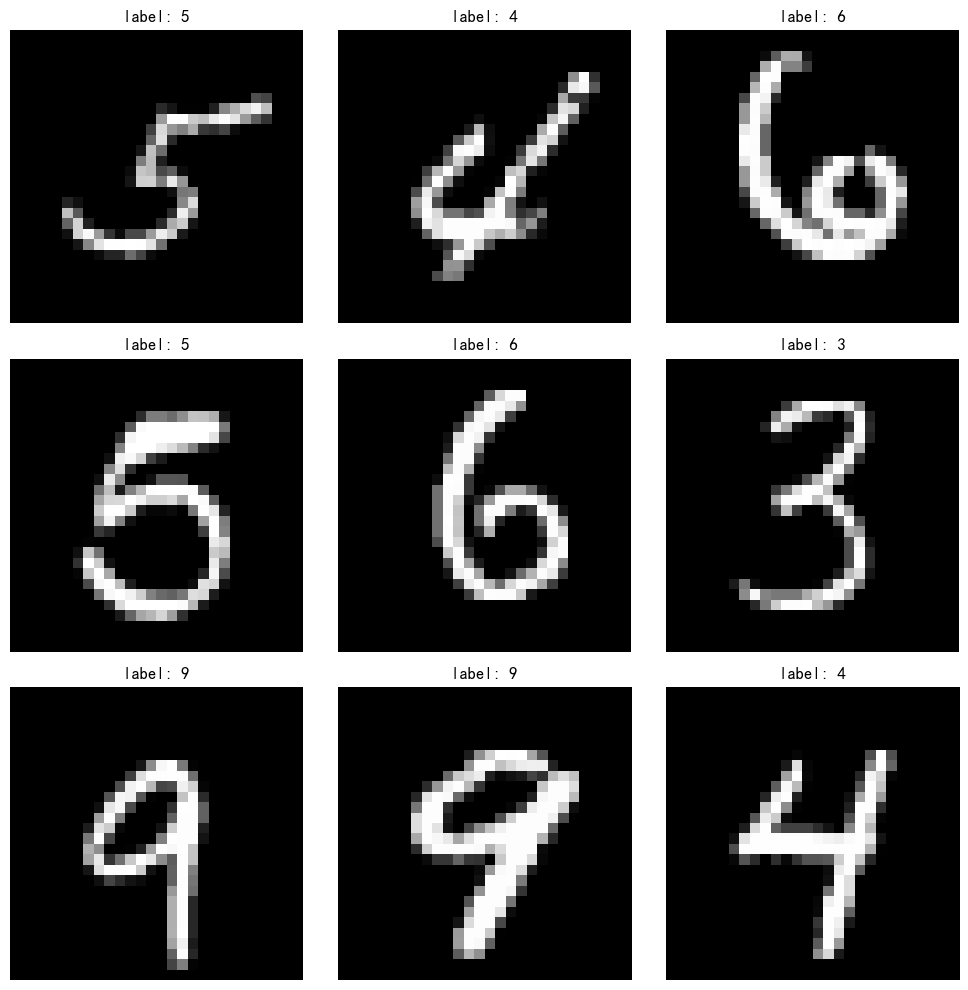

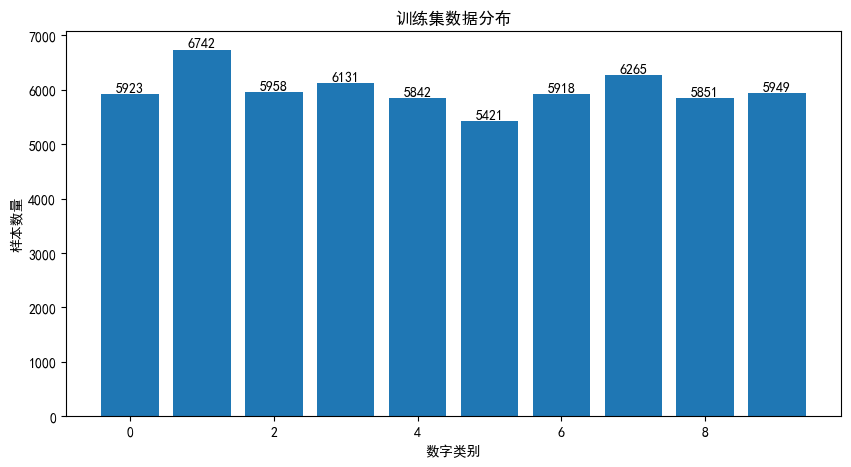

In [7]:
import numpy as np
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用 SimHei 字体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题
# 查看数据集规模
print(f"训练集大小: {len(trainset)}")
print(f"测试集大小: {len(testset)}")

# 获取一个批次的数据
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 打印图像张量的形状
print(f"\n单个图像张量形状: {images[0].shape}")
print(f"一个批次的图像张量形状: {images.shape}")

# 显示一个批次中的前9张图像
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'label: {labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# 查看标签分布
# 查看整个训练集的标签分布
all_labels = []
for _, labels in trainloader:
    all_labels.extend(labels.numpy())
unique_labels, counts = np.unique(all_labels, return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(unique_labels, counts)
plt.title('训练集数据分布')
plt.xlabel('数字类别')
plt.ylabel('样本数量')
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

train module

In [ ]:

model = DenseNetMNIST(num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    judge=0
    total = 0
    
    for inputs, labels in tqdm(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    if correct>judge:
            torch.save(model.state_dict(), 'densenet.pt')
            print("Model saved ")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {100 * correct / total:.2f}%")
model.eval()  
correct = 0
total = 0
with torch.no_grad():  
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")

100%|██████████| 235/235 [00:37<00:00,  6.25it/s]


Model saved 
Epoch [1/10], Loss: 0.2081, Accuracy: 93.30%


100%|██████████| 235/235 [00:35<00:00,  6.60it/s]


Model saved 
Epoch [2/10], Loss: 0.0514, Accuracy: 98.41%


100%|██████████| 235/235 [00:37<00:00,  6.28it/s]


Model saved 
Epoch [3/10], Loss: 0.0402, Accuracy: 98.71%


100%|██████████| 235/235 [00:37<00:00,  6.19it/s]


Model saved 
Epoch [4/10], Loss: 0.0330, Accuracy: 98.99%


100%|██████████| 235/235 [00:35<00:00,  6.70it/s]


Model saved 
Epoch [5/10], Loss: 0.0268, Accuracy: 99.18%


100%|██████████| 235/235 [00:36<00:00,  6.51it/s]


Model saved 
Epoch [6/10], Loss: 0.0240, Accuracy: 99.20%


100%|██████████| 235/235 [00:36<00:00,  6.39it/s]


Model saved 
Epoch [7/10], Loss: 0.0209, Accuracy: 99.36%


100%|██████████| 235/235 [00:36<00:00,  6.46it/s]


Model saved 
Epoch [8/10], Loss: 0.0183, Accuracy: 99.43%


100%|██████████| 235/235 [00:35<00:00,  6.66it/s]


Model saved 
Epoch [9/10], Loss: 0.0173, Accuracy: 99.46%


100%|██████████| 235/235 [00:34<00:00,  6.79it/s]


Model saved 
Epoch [10/10], Loss: 0.0153, Accuracy: 99.52%
Test Accuracy: 99.33%


识别单个照片数字

In [10]:
import cv2
# 加载训练好的模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseNetMNIST(num_classes=10).to(device=device)
model.load_state_dict(torch.load('./densenet.pt'))  # 加载训练好的权重
model.eval()  # 将模型设置为评估模式
# 图像预处理
transform = transforms.Compose([
    transforms.ToPILImage(),              # 将OpenCV读取的BGR图像转换为PIL图像
    transforms.Resize((28,28)),               # 调整尺寸
    transforms.ToTensor(),                # 转换为Tensor
    transforms.Normalize((0.5,), (0.5,))  # 归一化到[-1, 1]，如果是MNIST数据集这种标准化比较常见

])

image_path = './7.jpg'
image = cv2.imread(image_path)

# 转为灰度图并二值化
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY_INV)  # 反转黑白以便轮廓检测,100 magic number
cv2.imshow("binary_image", binary_image)
# 寻找轮廓
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 找到外接矩形
if len(contours) > 0:
    # 获取最大的外接矩形（假设只有一个数字）
    x, y, w, h = cv2.boundingRect(contours[0])

    # 裁剪图像到最小矩形
    cropped_image = binary_image[y:y + h, x:x + w]
    cv2.imshow("cropped_image", cropped_image)
    # 调整尺寸到28x28
    image = cv2.resize(cropped_image, (28, 28), interpolation=cv2.INTER_AREA)

    # 将裁剪后的图像显示出来（调试用）
    cv2.imshow("Cropped and Resized Image", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# image=cv2.bitwise_not(image)
# image =cv2.Canny(image,50,150)
# kernel = np.ones((3, 3), np.uint8)
# image = cv2.dilate(kernel=kernel,src=image,iterations=2)
# cv2.imshow("gray",image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
image = transform(image).unsqueeze(0)  # 增加batch维度
image = image.to(device)  # 将张量移动到目标设备
# 进行推理
with torch.no_grad():  # 禁用梯度计算
    output = model(image)
    _, predicted = torch.max(output, 1)  # 获取最大概率对应的标签
    predicted_label = predicted.item()  # 转换为Python整数

print(f'Predicted label: {output}')
print(f'Predicted label: {predicted_label}')


Predicted label: tensor([[-1.7977, 10.5462,  0.5946, -3.6278,  1.6531, -2.6732, -8.8833, 17.8417,
         -6.4120,  0.9102]], device='cuda:0')
Predicted label: 7


识别学号

In [9]:
import cv2
import torch
from torchvision import transforms
import numpy as np
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseNetMNIST(num_classes=10).to(device=device)
model.load_state_dict(torch.load('./densenet.pt'))  
model.eval()  

transform = transforms.Compose([
    transforms.ToPILImage(),              
    transforms.Resize((28, 28)),          
    transforms.ToTensor(),                
    transforms.Normalize((0.5,), (0.5,))  
])


# 读取输入图像
image_path = './whole.jpg'  
image = cv2.imread(image_path)

image=cv2.resize(image,(480, 360), interpolation=cv2.INTER_AREA)

# 转为灰度图并进行二值化
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray_image, 80, 255, cv2.THRESH_BINARY_INV)  # 反转黑白以便轮廓检测


kernel = np.ones((3, 3), np.uint8)
binary_enhanced = cv2.dilate(binary_image, kernel, iterations=1)
# cv2.imshow("binary_enhanced",binary_enhanced)
# cv2.imshow("binary_image",binary_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# 寻找轮廓
contours, _ = cv2.findContours(binary_enhanced, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 排序轮廓按从左到右顺序
contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
# 存储每个分割出的数字
digit_images = []

# 遍历每个轮廓并裁剪出数字区域
for contour in contours:
    #提取外界矩形
    x, y, w, h = cv2.boundingRect(contour)
    digit_image = binary_image[y:y + h, x:x + w]
    if w < 10:
        left_padding = (20 - w) // 2
        right_padding = 20 - w - left_padding
        digit_image = cv2.copyMakeBorder(
            digit_image, 0, 0, left_padding, right_padding, cv2.BORDER_CONSTANT, value=0
        )
    digit_images.append(digit_image)

print(f'Detected {len(digit_images)} digits.')

for i, digit_image in enumerate(digit_images):
    cv2.imshow(f"Digit {i+1}", digit_image)
    
    print(digit_image.shape)
    cv2.waitKey(0)

cv2.destroyAllWindows()


# # 创建一个用于保存分割数字的目录
# output_dir = './test'
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # 保存每个分割的数字图像
# for i, digit_image in enumerate(digit_images):
#     # 确保每个数字图像的大小是28x28（即MNIST的标准大小）
#     digit_image_resized = cv2.resize(digit_image, (28, 28), interpolation=cv2.INTER_AREA)

#     # 生成保存的文件路径（使用数字编号）
#     save_path = os.path.join(output_dir, f"digit_{i+1}.png")

#     # 保存数字图像
#     cv2.imwrite(save_path, digit_image_resized)

#     print(f"Saved: {save_path}")


# 对每个数字进行预测
predicted_labels = []

for digit_image in digit_images:
    # 将裁剪后的图像调整为28x28大小
    digit_image = cv2.resize(digit_image, (28, 28), interpolation=cv2.INTER_AREA)

    # 转换图像为模型所需的Tensor格式
    digit_image = transform(digit_image).unsqueeze(0)  # 增加batch维度
    digit_image = digit_image.to(device)  # 将图像移到目标设备

    # 进行推理
    with torch.no_grad():  # 禁用梯度计算
        output = model(digit_image)
        _, predicted = torch.max(output, 1)  # 获取最大概率对应的标签
        predicted_label = predicted.item()  # 转换为Python整数
        predicted_labels.append(predicted_label)

# 打印结果
print("Predicted sequence of digits:", predicted_labels)


Detected 10 digits.
(19, 26)
(18, 21)
(18, 20)
(20, 19)
(17, 21)
(19, 20)
(19, 21)
(30, 17)
(26, 21)
(27, 20)
Predicted sequence of digits: [2, 0, 2, 2, 2, 1, 2, 8, 8, 3]


通过TKinter的前端——落后

In [10]:
import cv2
import torch
from torchvision import transforms
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import torch.nn as nn
import torchvision.transforms as transforms

class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
    
    def forward(self, x):
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        return x

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(DenseLayer(in_channels, growth_rate))
            in_channels += growth_rate  # 每层输出通道数等于growth_rate
          
    def forward(self, x):
        for layer in self.layers:
            out = layer(x)
            x = torch.cat([x, out], 1)  # 将输入与当前层的输出连接
        return x

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
    
    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.pool(x)
        return x

class DenseNetMNIST(nn.Module):
    def __init__(self, num_classes=10, growth_rate=12, num_layers=6, num_blocks=4):
        super(DenseNetMNIST, self).__init__()
        
        # 初始卷积层
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        # 创建DenseNet的DenseBlock和TransitionLayer
        in_channels = 64
        self.dense_blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.dense_blocks.append(DenseBlock(num_layers, in_channels, growth_rate))
            in_channels += num_layers * growth_rate
            self.dense_blocks.append(TransitionLayer(in_channels, in_channels // 2))
            in_channels = in_channels // 2
        
        # 分类层
        self.fc = nn.Linear(in_channels, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        for block in self.dense_blocks:
            x = block(x)
        x = torch.flatten(x, 1)  # 展平为全连接层的输入
        x = self.fc(x)
        return x

# 图像预处理
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 载入训练好的模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseNetMNIST(num_classes=10).to(device=device)
model.load_state_dict(torch.load('./densenet.pt'))  # 加载训练好的权重
model.eval()  # 将模型设置为评估模式

# 创建Tkinter窗口
class DigitRecognitionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("数字识别")
        self.root.geometry("600x600")
        
        self.image_label = tk.Label(root, text="选择一张图片")
        self.image_label.pack(pady=20)
        
        self.select_button = tk.Button(root, text="选择图片", command=self.select_image)
        self.select_button.pack(pady=20)

        self.canvas = tk.Canvas(root, width=480, height=360)
        self.canvas.pack(pady=20)
        
        self.result_label = tk.Label(root, text="识别结果：", font=("Arial", 14))
        self.result_label.pack(pady=20)
        
        self.quit_button = tk.Button(root, text="退出", command=root.quit)
        self.quit_button.pack(pady=20)

    def select_image(self):
        file_path = filedialog.askopenfilename(title="选择图片", filetypes=[("Image files", "*.jpg;*.jpeg;*.png")])
        if not file_path:
            return
        
        # 读取并显示原始图像
        image = cv2.imread(file_path)
        if image is None:
            messagebox.showerror("错误", "无法加载图片")
            return
        
        image = cv2.resize(image, (480, 360), interpolation=cv2.INTER_AREA)
        
        # 转为灰度图并进行二值化
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary_image = cv2.threshold(gray_image, 80, 255, cv2.THRESH_BINARY_INV)
        
        kernel = np.ones((3, 3), np.uint8)
        binary_enhanced = cv2.dilate(binary_image, kernel, iterations=1)
        
        # 寻找轮廓
        contours, _ = cv2.findContours(binary_enhanced, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
        
        # 存储每个分割出的数字
        digit_images = []
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            digit_image = binary_image[y:y + h, x:x + w]
            # 添加上下2像素的黑色边框
            digit_image = cv2.copyMakeBorder(
                digit_image,
                5,  # 上边填充2像素
                5,  # 下边填充2像素
                9,  # 暂时不填充左边
                9,  # 暂时不填充右边
                cv2.BORDER_CONSTANT,
                value=0
            )
            # if w < 10:
            #     # 计算需要添加的左边和右边的黑色像素数
            #     left_padding = (20 - w) // 2
            #     right_padding = 20 - w - left_padding

            #     # 添加黑色边框
            #     digit_image = cv2.copyMakeBorder(
            #         digit_image, 0, 0, left_padding, right_padding, cv2.BORDER_CONSTANT, value=0
            #     )
            digit_images.append(digit_image)
        
        # 将每个数字图像调整为28x28，并拼接成一张大图
        resized_digits = []
        for digit_image in digit_images:
            resized_digit = cv2.resize(digit_image, (28, 28), interpolation=cv2.INTER_AREA)
            resized_digits.append(resized_digit)
        
        # 将每个28x28的图像水平拼接
        if resized_digits:
            # 使用np.hstack拼接每个28x28图像
            concatenated_image = np.hstack(resized_digits)
        
        # 对每个数字进行预测
        predicted_labels = []
        for digit_image in digit_images:
            digit_image_resized = cv2.resize(digit_image, (28, 28), interpolation=cv2.INTER_AREA)
            digit_image_tensor = transform(digit_image_resized).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(digit_image_tensor)
                _, predicted = torch.max(output, 1)
                predicted_labels.append(predicted.item())
        
        self.display_result(concatenated_image, predicted_labels)


    def display_result(self, concatenated_image, predicted_labels):
        self.result_label.config(text="识别结果: " + ''.join(map(str, predicted_labels)))
        concatenated_image_rgb = cv2.cvtColor(concatenated_image, cv2.COLOR_BGR2RGB)
        
    
        pil_image = Image.fromarray(concatenated_image_rgb)
        
        img_tk = ImageTk.PhotoImage(pil_image)
        
        self.canvas.delete("all")
        self.canvas.create_image(0, 0, image=img_tk, anchor=tk.NW)
        
        # 保持对图像的引用，防止被垃圾回收
        self.canvas.image = img_tk




if __name__ == "__main__":
    root = tk.Tk()
    app = DigitRecognitionApp(root)
    root.mainloop()